Librerias

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models,utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from configparser import ConfigParser
from ModelSelector import  ModelSelector
from tensorflow.keras.metrics import Precision,Recall,AUC,Accuracy,F1Score,FalseNegatives,FalsePositives,MeanAbsoluteError
from keras.callbacks import EarlyStopping
import scipy


Esta parte del código se encarga de a partir de un conjunto de imagenes en carpetas divididas en n clases 

In [2]:
configfile_name = "config.ini" 
config= ConfigParser()
config.read(configfile_name)
image_size = int(config.get("dataset","image_size"))
color_mode=config.get("dataset","color_mode")
batch_size = int(config.get("dataset","batch_size"))
base_dir=config.get("dataset","base_dir")

In [3]:
#Dividir la data en train, validation y test
from SplitData import SplitData
data=SplitData()
data.split()

0.4
0.4
0.4


OSError: [WinError 145] El directorio no está vacío: 'Nuevo'

Data Augmentation

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,                # Normalización de imágenes
    rotation_range=20,             # Rotar hasta 20 grados
    width_shift_range=0.2,         # Desplazamiento horizontal
    height_shift_range=0.2,        # Desplazamiento vertical
    shear_range=0.2,               # Cizallamiento
    zoom_range=0.2,                # Zoom aleatorio
    horizontal_flip=True,          # Flip horizontal
    fill_mode='nearest'            # Método de relleno para píxeles vacíos
)

Lectura de datos

In [4]:
train_ds = datagen.flow_from_directory(
    directory=os.path.join('Nuevo', 'train'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode
)

# Cargar datos de validación
val_ds = datagen.flow_from_directory(
    directory=os.path.join('Nuevo', 'val'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode

)

# Cargar datos de prueba
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join('Nuevo', 'test'),
    image_size=(image_size, image_size),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode=color_mode

)


Found 96 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Found 34 files belonging to 3 classes.


Cargar un modelo preentrenado

In [6]:
# Crear una instancia de ModelSelector
selector = ModelSelector(image_size=image_size, color_space='RGB', model='resnet50')
# Cargar el modelo especificado
selected_model = selector.load_model()
# Mostrar la arquitectura del modelo
selected_model.summary()



94765736/94765736 [==============================] - 11s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 102, 102, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 48, 48, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1_conv[0][0]']          
 on)                   

In [7]:

# Definir el modelo
model = models.Sequential([
    selected_model,
    layers.GlobalMaxPooling2D(),  # Global Max Pooling
    layers.Dense(train_ds.num_classes, activation='softmax')  # Output layer for 20 classes

])

# Mostrar un resumen del modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23593859 (90.00 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
%load_ext tensorboard

In [8]:
checkpoint_filepath = './ckpt_resnet/ckpt/checkpoint_{epoch}.keras'
log_dir="./ckpt_resnet"

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='precision', patience=10, restore_best_weights=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,verbose=1,    save_best_only=True,
)

Metricas

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Cambiar a 'sparse_categorical_crossentropy' si las etiquetas no están en formato one-hot
    metrics=[Precision(), Recall(), AUC(), 'accuracy', FalseNegatives(), FalsePositives(), MeanAbsoluteError()]
)


Train

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Puedes ajustar el número de épocas,
    callbacks=[tensorboard_callback, model_checkpoint_callback,early_stopping]
)


Epoch 1/20


3/3 [==============================] - ETA: 0s - loss: 1.4684 - precision_1: 0.5000 - recall_1: 0.5000 - auc_1: 0.5439 - accuracy: 0.5000 - false_negatives_1: 48.0000 - false_positives_1: 48.0000 - mean_absolute_error: 0.3901
Epoch 1: val_loss improved from inf to 1.28656, saving model to ./ckpt_resnet/ckpt\checkpoint_1.keras
3/3 [==============================] - 34s 12s/step - loss: 1.4684 - precision_1: 0.5000 - recall_1: 0.5000 - auc_1: 0.5439 - accuracy: 0.5000 - false_negatives_1: 48.0000 - false_positives_1: 48.0000 - mean_absolute_error: 0.3901 - val_loss: 1.2866 - val_precision_1: 0.5000 - val_recall_1: 0.5000 - val_auc_1: 0.5769 - val_accuracy: 0.5000 - val_false_negatives_1: 16.0000 - val_false_positives_1: 16.0000 - val_mean_absolute_error: 0.3932
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 1.2233 - precision_1: 0.5000 - recall_1: 0.5000 - auc_1: 0.5790 - accuracy: 0.5000 - false_negatives_1: 48.0000 - false_positives_1: 48.0000 - mean_abs

TensorBoard

In [15]:
%tensorboard --logdir './ckpt_resnet' --port=7001

In [17]:
test_acc = model.evaluate(test_ds)
print(test_acc)
formatted_string = "Values: {}".format(", ".join(map(str, test_acc)))
print(formatted_string)

2/2 [==============================] - 1s 52ms/step - loss: 2.5130 - precision: 0.5000 - recall: 0.5000 - auc: 0.5614 - accuracy: 0.5000 - false_negatives: 17.0000 - false_positives: 17.0000 - mean_absolute_error: 0.3447
[2.512974262237549, 0.5, 0.5, 0.5614186525344849, 0.5, 17.0, 17.0, 0.34468382596969604]
Values: 2.512974262237549, 0.5, 0.5, 0.5614186525344849, 0.5, 17.0, 17.0, 0.34468382596969604


In [18]:
model.save('model.h5')

c:\Users\Sebas\Desktop\Tesis\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
y_pred=model.predict(test_ds)
y_pred_label=np.argmax(y_pred, axis=1)

2/2 [==============================] - 2s 34ms/step


In [20]:
import numpy as np
import tensorflow as tf

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Obtener la clase predicha
    true_labels.extend(np.argmax(labels, axis=1))  # Obtener la clase verdadera

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


1/1 [==============================] - 1s 1s/step


In [22]:
print(true_labels)
print(predicted_labels)

[0 1 1 1 1 1 1 0 2 2 2 1 1 2 2 1 2 2 2 0 1 1 1 2 0 1 0 2 1 1 1 2 1 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Matriz de confusión

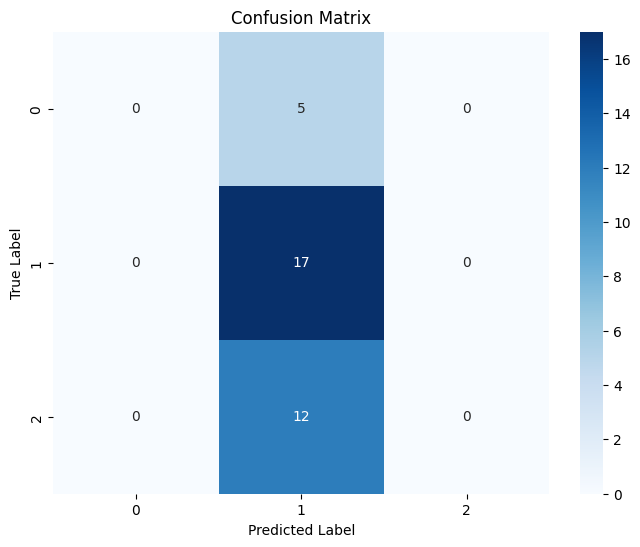

In [25]:
# Crear la matriz de confusión
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convertir a numpy para facilitar la visualización
cm = cm.numpy()

# Visualizar la matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Predicit

In [14]:
import tensorflow as tf

# Cargar el modelo 
model = tf.keras.models.load_model('model.h5')

# Cargar la imagen
img = tf.keras.preprocessing.image.load_img('Nuevo/test/Mala/IMG_20240928_155035_769.jpg', target_size=(96, 96))

# Convertir la imagen a un array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Añadir una dimensión extra
img_array = tf.expand_dims(img_array, 0)

# Predecir la clase de la imagen
predictions = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
